In [0]:
#https://github.com/chriskhanhtran/bert-for-sentiment-analysis
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
data = pd.read_csv("/content/drive/My Drive/BERT/CSV_FINAL_EQUALIZADO.csv")
data = data.drop(["Unnamed: 0", "review_rate"], axis=1)
data.head()

,review_body,RESULTADO_BINARIO
0,Excelente experiência !! Atendimento impecável...,1
1,"Local agradável, porém, já fui em melhores, co...",0
2,Esta é a “milésima” vez que venho a este resta...,1
3,"O local, o atendimento e a comida, sensacionai...",1
4,"Comida espetacular, atendimento ímpar! Frank e...",1


In [0]:
data['RESULTADO_BINARIO'].value_counts()

1    16427
0    16427
Name: RESULTADO_BINARIO, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

X = data.review_body.values
y = data.RESULTADO_BINARIO.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [0]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [0]:
#===============BASELINE===============================================


import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    #s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('portuguese')])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
  
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Acurácia: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Curva ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taxa de true positive')
    plt.xlabel('Taxa de false positive ')
    plt.show()

In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 9.2MB/s 
     |████████████████████████████████| 1.0MB 52.4MB/s 
     |████████████████████████████████| 3.7MB 63.2MB/s 
     |████████████████████████████████| 890kB 59.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=b79c696e50927adce4ee877cb012895cc9411c171f5bae105205c6b41050b757
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    #text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    #text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [0]:
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  Excelente experiência !! Atendimento impecável do funcionário Franklin. Comida excepcional e ambiente muito agradável. Recomendo!!
Processed:  Excelente experiência !! Atendimento impecável do funcionário Franklin. Comida excepcional e ambiente muito agradável. Recomendo!!


In [0]:
from transformers import BertTokenizer, AutoModel, AutoTokenizer

# Load the BERT tokenizer
#tokenizer = BertTokenizer.from_pretrained('vocab.txt', do_lower_case=True)
#tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [0]:

encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in data.review_body]


max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  1678


In [0]:
MAX_LEN = 256

token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)


print('Tokenizando os dados...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  Excelente experiência !! Atendimento impecável do funcionário Franklin. Comida excepcional e ambiente muito agradável. Recomendo!!
Token IDs:  [101, 18116, 403, 4040, 106, 106, 7354, 5154, 6554, 7775, 415, 171, 13222, 14222, 119, 761, 328, 21300, 122, 3580, 785, 19260, 119, 2325, 3309, 214, 106, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
T

In [0]:
#CRIANDO O DATALOADER:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)


batch_size = 16


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [0]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel, AutoModel


class BertClassifier(nn.Module):
   
    def __init__(self, freeze_bert=False):
     
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2

    
        #self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        #self.bert = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
        self.bert = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
         
            nn.Linear(H, D_out)
        )

      
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
         
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
      
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 59 µs, sys: 1e+03 ns, total: 60 µs
Wall time: 63.2 µs


In [0]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,   
                      eps=1e-8  
                      )

    
    total_steps = len(train_dataloader) * epochs

    
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [0]:
import random
import time


loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
   
    print("Treino iniciado...\n")
    for epoch_i in range(epochs):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Tempo':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

       
        total_loss, batch_loss, batch_counts = 0, 0, 0

        
        model.train()

        
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            
            model.zero_grad()

           
            logits = model(b_input_ids, b_attn_mask)

          
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

          
            loss.backward()

        
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          
            optimizer.step()
            scheduler.step()

      
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
              
                time_elapsed = time.time() - t0_batch

                
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

              
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

            
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
  
        if evaluation == True:
           
            val_loss, val_accuracy = evaluate(model, val_dataloader)

         
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Fim da etapa de treinamento!")
    torch.save(model.state_dict(), '/content/drive/My Drive/BERT/'+"modelo_pronto_2_"+str(epoch_i))

def evaluate(model, val_dataloader):
   
    model.eval()


    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
       
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

     
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

       
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        
        preds = torch.argmax(logits, dim=1).flatten()

       
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

   
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [0]:
set_seed(42)    
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2)

Treino iniciado...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |   Tempo  
----------------------------------------------------------------------
   1    |   20    |   0.475055   |     -      |     -     |   8.61   
   1    |   40    |   0.331030   |     -      |     -     |   8.17   
   1    |   60    |   0.333525   |     -      |     -     |   8.17   
   1    |   80    |   0.352305   |     -      |     -     |   8.17   
   1    |   100   |   0.248647   |     -      |     -     |   8.18   
   1    |   120   |   0.352766   |     -      |     -     |   8.17   
   1    |   140   |   0.273467   |     -      |     -     |   8.18   
   1    |   160   |   0.319543   |     -      |     -     |   8.17   
   1    |   180   |   0.378190   |     -      |     -     |   8.19   
   1    |   200   |   0.307979   |     -      |     -     |   8.19   
   1    |   220   |   0.229525   |     -      |     -     |   8.19   
   1    |   240   |   0.339323   |     -      |     -     |   8.19   

AUC: 0.9680
Acurácia: 91.39%


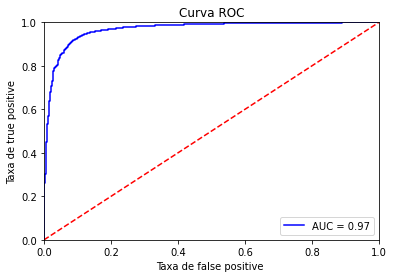

In [0]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):

    model.eval()

    all_logits = []


    for batch in test_dataloader:
        
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
   
    all_logits = torch.cat(all_logits, dim=0)

   
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

#EVALUATION================================

probs = bert_predict(bert_classifier, val_dataloader)
evaluate_roc(probs, y_val)

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/BERT/modelotreinado')

NameError: ignored

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
preds = probs[:, 1]
print(' acc = ', accuracy_score(y_val, preds.round()), ("\n"),
      'prec = ', precision_score(y_val, preds.round()), ("\n"),
      'recall = ', recall_score(y_val, preds.round()), ("\n"),
      'f1 = ', f1_score(y_val, preds.round()))

 acc =  0.9138770541692027 
 prec =  0.9164648910411622 
 recall =  0.9125979505726342 
 f1 =  0.9145273331319843


In [0]:
model = bert_classifier.load_state_dict(torch.load('/content/drive/My Drive/BERT/'+"modelo_pronto_2_1"))

In [0]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=2)

Treino iniciado...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |   Tempo  
----------------------------------------------------------------------
   1    |   20    |   0.112052   |     -      |     -     |   8.60   
   1    |   40    |   0.077526   |     -      |     -     |   8.16   
   1    |   60    |   0.075181   |     -      |     -     |   8.16   
   1    |   80    |   0.137201   |     -      |     -     |   8.17   
   1    |   100   |   0.095188   |     -      |     -     |   8.17   
   1    |   120   |   0.143391   |     -      |     -     |   8.17   
   1    |   140   |   0.079623   |     -      |     -     |   8.20   
   1    |   160   |   0.122981   |     -      |     -     |   8.17   
   1    |   180   |   0.068324   |     -      |     -     |   8.17   
   1    |   200   |   0.088698   |     -      |     -     |   8.16   
   1    |   220   |   0.094269   |     -      |     -     |   8.16   
   1    |   240   |   0.081968   |     -      |     -     |   8.17   